## Experiment 7.3 speech production preprocess

### load packages, set up functions, and group-level data directory

In [1]:
# %% this file read a column of words from a csv file and write them into txt files, 

import pandas as pd
import os
import subprocess
import textgrid
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
import numpy as np
import scipy.stats as stats
from IconFirstTrialOrder import iconfirst_trialOrder
from IconFirstWordTypeOrder import iconfirst_wordTypeOrder
from PictureFirstTrialOrder import picturefirst_trialOrder
from PictureFirstWordTypeOrder import picturefirst_wordTypeOrder
import warnings
warnings.filterwarnings('ignore')

# specify whether "control" in the TrialOrder file is nouncontrol or verbcontrol
for i, item in enumerate(iconfirst_trialOrder):
    if item == "contrl":
        if iconfirst_wordTypeOrder[i].startswith("obj"):
            iconfirst_trialOrder[i] = "nouncontrol"
        elif iconfirst_wordTypeOrder[i].startswith("act"):
            iconfirst_trialOrder[i] = "verbcontrol"
            
for i, item in enumerate(picturefirst_trialOrder):
    if item == "contrl":
        if picturefirst_wordTypeOrder[i].startswith("obj"):
            picturefirst_trialOrder[i] = "nouncontrol"
        elif picturefirst_wordTypeOrder[i].startswith("act"):
            picturefirst_trialOrder[i] = "verbcontrol"

# Remove periods from the text
def remove_punctuation(text):
    return re.sub(r'\.', '', text)

# Function to expand the target into all possible pronoun variations, for example, "He/She/They/It melted" into a list of ["he melted", "she melted", "they melted", "it melted"]
def expand_target(target):
    # Initialize pronouns list
    pronouns = []
    
    # Check if the target contains a pronoun group
    if re.search(r'He/She/They/It', target, re.IGNORECASE):
        pronouns = ['he', 'she', 'they', 'it']
    # If no pronoun group, return the target as a single-item list
    elif not pronouns:
        return [target.strip()]
    
    # Replace the pronoun group with each pronoun and create a list of variations
    expanded_targets = []
    for pronoun in pronouns:
        expanded_target = re.sub(r'He/She/They/It', pronoun, target, flags=re.IGNORECASE)
        expanded_target = remove_punctuation(expanded_target)
        expanded_targets.append(expanded_target.strip())
    return expanded_targets

data_dir = '/Users/yiwei/Dropbox/agrammatism/MEGstudy/speechProductionData/'
sessions = ['IF', 'PF']


### set up subject-level file directories

In [2]:
subject_id = 'R3204'
subject_folder = os.path.join(data_dir,subject_id)
wavs_dir = os.path.join(data_dir,subject_id,'wavs')

### generate .txt file per .wav file using the transcription

In [4]:
# remove all the .txt files in the folder. 
subprocess.run(f'rm {wavs_dir}/*.txt', shell=True)

# Using the "response" column in the transcription file to generate the txt files.
for session in sessions:
    # print(session)
    transcription_file = glob(os.path.join(data_dir,subject_folder, f"{subject_id}_{session}.xlsx"))
    # need to access the transcription file, and turn the transcription into .txt files
    transcript_df = pd.read_excel(transcription_file[0])

    # Loop over the DataFrame rows
    for index, row in transcript_df.iterrows():
        # print(index)
        # print(row)
        content = row['response']
        # Define the name of the text file
        txt_file_name = f"{subject_id}_{session}_{int(row['trial']):03}.txt"

        # Define the path to the text file
        txt_file_path = os.path.join(wavs_dir, txt_file_name)
        if not content:
            content = ""
        
        content = str(content)
            
        # Add the key-value pair to the dictionary, where the value is the third column of the current row
        with open(txt_file_path, 'w') as files:
            files.write(content)
        
    wav_files = glob(os.path.join(wavs_dir, f'*{session}*.wav'))
    txt_files = glob(os.path.join(wavs_dir, f'*{session}*.txt'))
    print(f"Number of .wav files: {len(wav_files)} for {session} session")
    print(f"Number of .txt files: {len(txt_files)} generated for {session} session")
    
    if len(wav_files) != len(txt_files):
        wav_name = {os.path.splitext(os.path.basename(file))[0] for file in wav_files}
        txt_name = {os.path.splitext(os.path.basename(file))[0] for file in txt_files}
        missing_txt_files = wav_name - txt_name
        print(f"Missing txt files: {missing_txt_files}")

Number of .wav files: 400 for IF session
Number of .txt files: 400 generated for IF session
Number of .wav files: 400 for PF session
Number of .txt files: 400 generated for PF session


### apply MFA to each .txt/.wav file pair and get a .TextGrid file with word onset time for each target word

In [5]:
# Define the command and arguments
subprocess.run(f'rm {wavs_dir}/*.TextGrid', shell=True)

# Define the command and arguments
command = 'mfa'
args1 = ['server', 'start']
args2 = ['align', '--clean', '--use_postgres', '--overwrite', wavs_dir, 'english_mfa', 'english_mfa', wavs_dir]

# Run the command
subprocess.run([command] + args1)
subprocess.run([command] + args2)

wav_files = glob(os.path.join(wavs_dir, '*.wav'))
txt_files = glob(os.path.join(wavs_dir, '*.txt'))
textgrid_files = glob(os.path.join(wavs_dir, '*.TextGrid'))
print(f"Number of total .wav files: {len(wav_files)}")
print(f"Number of total .txt files: {len(txt_files)} generated")
print(f"Number of total .TextGrid files: {len(textgrid_files)} generated")

if len(textgrid_files) != len(wav_files):
    wav_name = {os.path.splitext(os.path.basename(file))[0] for file in wav_files}
    textgrid_name = {os.path.splitext(os.path.basename(file))[0] for file in textgrid_files}
    missing_textgrid_files = wav_name - textgrid_name
    print(f"Missing TextGrid files: {missing_textgrid_files}")


rm: /Users/yiwei/Dropbox/agrammatism/MEGstudy/speechProductionData/R3204/wavs/*.TextGrid: No such file or directory
 INFO     Setting up corpus information...                                      
 INFO     Loading corpus from source files...                                   


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/100  [ 0:00:01 < 0:00:00 , ? it/s ]


 INFO     Found 1 speaker across 800 files, average number of utterances per    
          speaker: 800.0                                                        
 INFO     Initializing multiprocessing jobs...                                  
 WARNING  Number of jobs was specified as 3, but due to only having 1 speakers, 
          MFA will only use 1 jobs. Use the --single_speaker flag if you would  
          like to split utterances across jobs regardless of their speaker.     
 INFO     Normalizing text...                                                   


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/800  [ 0:00:01 < 0:00:00 , ? it/s ]


 INFO     Generating MFCCs...                                                   


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/800  [ 0:00:10 < 0:00:00 , 117 it/s ]t/s ]t/s ]
  81% ━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━ 648/800  [ 0:00:00 < -:--:-- , ? it/s ]

 INFO     Calculating CMVN...                                                   
 INFO     Generating final features...                                          


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/800  [ 0:00:01 < 0:00:00 , 148 it/s ]t/s ]t/s ]
   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/800  [ 0:00:00 < -:--:-- , ? it/s ]

 INFO     Creating corpus split...                                              


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/800  [ 0:00:01 < 0:00:00 , ? it/s ]


 INFO     Compiling training graphs...                                          
 INFO     Performing first-pass alignment...                                    
 INFO     Generating alignments...                                              


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/800  [ 0:00:05 < 0:00:00 , 159 it/s ]200 it/s ]
   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/800  [ 0:00:00 < -:--:-- , ? it/s ]

 INFO     Calculating fMLLR for speaker adaptation...                           


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 799/800  [ 0:00:02 < 0:00:01 , 581 it/s ]t/s ]
   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/800  [ 0:00:00 < -:--:-- , ? it/s ]

 INFO     Performing second-pass alignment...                                   
 INFO     Generating alignments...                                              


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/800  [ 0:00:04 < 0:00:00 , 171 it/s ]t/s ]t/s ]
   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/800  [ 0:00:00 < -:--:-- , ? it/s ]

 INFO     Collecting phone and word alignments from alignment lattices...       


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/800  [ 0:00:01 < 0:00:00 , 671 it/s ]1m4,420 it/s ]
   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/800  [ 0:00:00 < -:--:-- , ? it/s ]

 INFO     Analyzing alignment quality...                                        


  99% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 795/800  [ 0:00:01 < 0:00:01 , 461 it/s ]t/s ]


 INFO     Exporting alignment TextGrids to                                      
          /Users/yiwei/Dropbox/agrammatism/MEGstudy/speechProductionData/R3204/w
          avs...                                                                


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800/800  [ 0:00:00 < 0:00:00 , 2,863 it/s ]1m2,329 it/s ]


 INFO     Finished exporting TextGrids to                                       
          /Users/yiwei/Dropbox/agrammatism/MEGstudy/speechProductionData/R3204/w
          avs!                                                                  
 INFO     Done! Everything took 43.282 seconds                                  


Number of total .wav files: 800
Number of total .txt files: 800 generated
Number of total .TextGrid files: 800 generated


### extract word onset time from each .TextGrid file and generate a .csv file (wordOnsetTime.csv)

In [6]:
for session in sessions:
    
    # Create an empty DataFrame to store the results
    results = pd.DataFrame(columns=['filename', 'subject', 'trial', 'wordType', 'target', 'response', 'MFA_sentence_onset', 'incorrect'])

    # get the transcription file for the current subject and session
    transcription_file = glob(os.path.join(data_dir,subject_folder, f"{subject_id}_{session}.xlsx"))
    # read the transcription file as a dataframe
    transcript_df = pd.read_excel(transcription_file[0])
    
    # Get all the TextGrid files in the directory for the current subject and session
    textgrid_files = glob(os.path.join(wavs_dir, f"{subject_id}_{session}*.TextGrid"))
    
    # Loop over theTextGrid files
    for file in textgrid_files:   
        
        # Extract the file name, and trial number from the file name
        file_name = os.path.basename(file).split('.')[0]
        trial_no = str(int(file_name.split('_')[2]))
        
        # Get the word type for the current trial
        if session == 'PF':
            wordType = picturefirst_trialOrder[int(trial_no)-1]
        elif session == 'IF':
            wordType = iconfirst_trialOrder[int(trial_no)-1]  
            
        # Get the target word/phrase for the current trial
        target = transcript_df.loc[transcript_df['trial'].astype(str) == trial_no, 'item'].values[0]

        # Get the response for the current trial
        response = transcript_df.loc[transcript_df['trial'].astype(str) == trial_no, 'response'].values[0]

        # if the response is different from the target, a "d" is marked in the "d = different" column.
        different = transcript_df.loc[transcript_df['trial'].astype(str) == trial_no, 'd = different'].values[0]

        # if the response is different from the target, but still consider correct, a "c" is marked in the "c = correct" column.
        correct = transcript_df.loc[transcript_df['trial'].astype(str) == trial_no, 'c = correct'].values[0]

        # when a response is different form the target, but still consider correct, there are two possibilities:
        # 1. Due to this is a picture naming task, sometimes participants may interpret the picture meaning differently,
        #    for example, they say "orange", when the target is "peach", or "steam" when the target is "smoke",
        #    in this case, their answers are still considered correct, as long as they interpret the icon correctly,
        #    and the onset time of the first word should be used (just like the other correct trials), then a "f" is marked in the "f = first word" column.
        #    This is taken care of by the 1st if statement below.
        # 2. Sometimes, participants may give a wrong response first, then correct themselves, 
        #    or they might have filler words like "um" or "uh" before producing the correct response,
        #    in this case, the onset time of the last time the correct answer showed up in their response should be used.
        #    This is taken care of by the 2nd if statement below.
        firstWordOnset = transcript_df.loc[transcript_df['trial'].astype(str) == trial_no, 'f = first word'].values[0]

        # fill in the new row with the extracted information above
        new_row = pd.DataFrame({
                    'filename': [file_name],
                    'subject': [subject_id],
                    'trial': [trial_no],
                    'wordType': [wordType],
                    'target': [target],
                    'response': [response],
                    })
        
        # If the target has multiple pronouns to choose from, expand the target into all possible pronoun variations
        target_text = expand_target(target)
        
        # Read the TextGrid file
        textGridFile = textgrid.TextGrid.fromFile(os.path.join(wavs_dir, file))
        
        # Extract the response from the TextGrid file, and join words in different intervals into a single string, excluding intervals with no text
        response_text = []
        for interval in textGridFile.tiers[0].intervals:
            response_text.append(interval.mark)
        response_text = ' '.join(filter(None, response_text))
        
        # extract the word tier and intervals from the TextGrid file
        wordTier = textGridFile.tiers[0]
        intervals = wordTier.intervals
        
        
        # if the response is different from the target, but considered correct, and the onset of the first word should be used, 
        # then the MFA onset time is the onset time of the first word in the response.
        if different == 'd' and correct == 'c' and firstWordOnset == 'f':
            # print(f'session = {session}, trial = {trial_no}, response = {response_text}, 1st if statement')
            for interval in intervals:
                if interval.mark == response_text.split(' ')[0]:
                    new_row['MFA_sentence_onset'] = interval.minTime
                    # print(interval.mark)
                    # print(interval.minTime)
                    break
        
        
        # if the response is different from the target, but considered correct, and the onset of the first word shouldn't be used, 
        # then the MFA onset time is the onset time of last time the correct answer showed up in their response.
        if different == 'd' and correct == 'c' and firstWordOnset != 'f':
            # print(f'session = {session}, trial = {trial_no}, response = {response_text}, 2nd if statement')
            # getthe number of words in the target and response
            no_of_words_in_target = len(target_text[0].split())
            no_of_words_in_response = len(response_text.split())
            # since the onset of the frist word should not be used, we need to find the onset of the last time the correct answer showed up in their response.
            # to do so, depending on how many words are in the target, I search the same number of words in the response at a time, from the second word in the response to the end.
            # for example, if there are 3 words in the target, and 7 words in the response, starting from the 2nd word in the response, 
            # I search 3 words at a time, until I find a match with the target, then I use the onset time of the first word in the match as the onset time.
            for i in range(1,no_of_words_in_response): 
                response_search = response_text.split()[i:i+no_of_words_in_target]
                response_search = ' '.join(filter(None, response_search))
                # looking for match regardless of the case
                if any(t.lower() in response_search.lower() for t in target_text):
                    # mostlikely the correct response showed up in the last few words of the response, so I search from the last interval backwards,
                    # until I find the interval that matches the first word in the match, I use the minTime of that interval as the MFA onset time.
                    for interval in reversed(intervals):
                        if interval.mark == response_text.split(' ')[i]:
                            new_row['MFA_sentence_onset'] = interval.minTime
                            # since this is a more complicated case, I mark it with a flag, so that these cases can be checked manually later if needed.
                            new_row['flag'] = 'flag'
                            break
                        
                        
        # if the response is different from the target, and considered incorrect, then the onset time is None, also mark the incorrect column with 1 for incorrect
        if different == 'd' and correct != 'c' and firstWordOnset != 'f':
            # print(f'session = {session}, trial = {trial_no}, response = {response_text}, 3rd if statement')
            new_row['incorrect'] = 1
            new_row['MFA_sentence_onset'] = None
            

        # if the response is the same as the target, or is one of the possible correct answers based on the target,
        # then the onset time is the onset time of the first word in the response
        if different != 'd' and correct != 'c' and firstWordOnset != 'f':
            # print(f'session = {session}, trial = {trial_no}, response = {response_text}, 4th if statement, {different}')
            if any(t.lower() in response_text.lower() for t in target_text):
                for interval in intervals:
                    if interval.mark == response_text.split(' ')[0]:
                        # print(interval.mark)
                        new_row['MFA_sentence_onset'] = interval.minTime
                        break 
            # if the response does not belong to one of the possible correct answers based on the target (but was also NOT marked as different and/or incorrect), 
            # then the onset time is None, also mark the incorrect column with 1 for incorrect, and mark it with a flag, so that these cases can be checked manually later if needed.
            else:
                new_row['incorrect'] = 1
                new_row['MFA_sentence_onset'] = None               
                new_row['flag'] = 'flag'    
        
        results = pd.concat([results, new_row], ignore_index=True)
    
     
        
    # if the onset time is less than 0.5, mark it with a flag, so that these cases can be checked manually later if needed.
    results.loc[results['MFA_sentence_onset'] < 0.5, 'flag'] = 'flag'
    
    # Save the results to a .csv file
    results.to_csv(os.path.join(data_dir + subject_id + f"/{subject_id}_{session}_responseOnsetTime.csv"), index=False)

### plot individual subject' word onset times by condition 

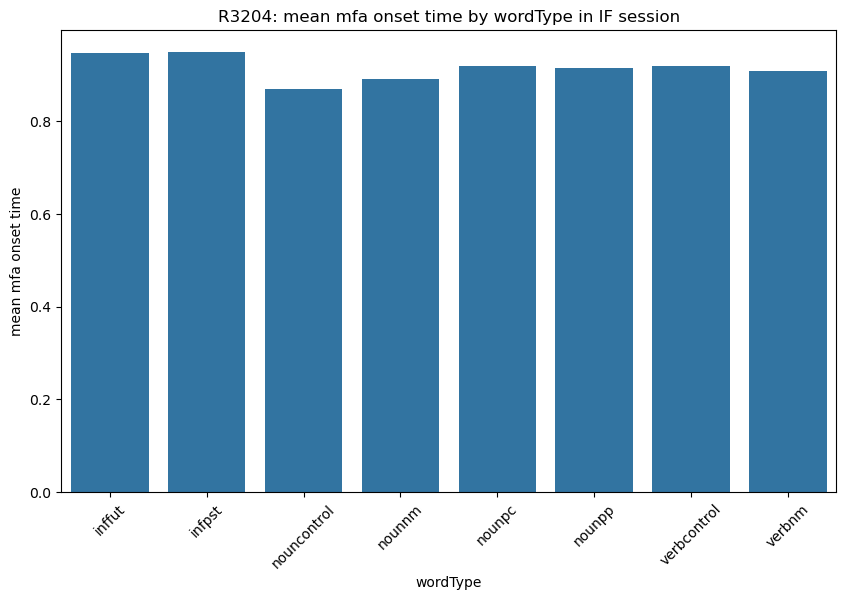

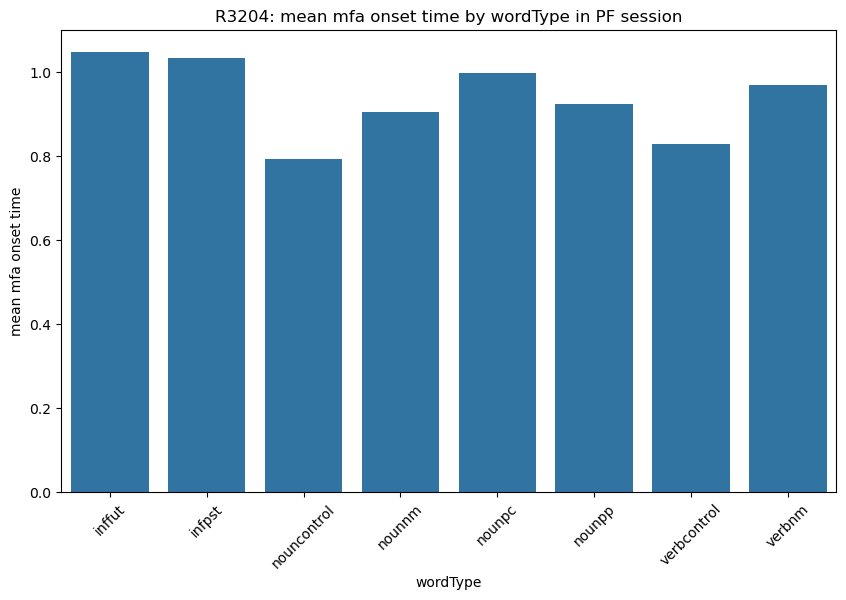

In [7]:
subject_id = subject_id

for session in sessions:
    results = pd.read_csv(os.path.join(data_dir,subject_id,f"{subject_id}_{session}_responseOnsetTime.csv"))    
    filtered_results = results[(results['flag'] != 'flag') & (results['incorrect'] != str(1))]
    
    # Group by condition and calculate mean MFA_onset_time for each condition
    mean_mfa_onset_time = filtered_results.groupby('wordType').agg({'MFA_sentence_onset':'mean'}).reset_index()

    # plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='wordType', y='MFA_sentence_onset', data=mean_mfa_onset_time, errorbar='sd')
    plt.title(f'{subject_id}: mean mfa onset time by wordType in {session} session')
    plt.xlabel("wordType")
    plt.ylabel("mean mfa onset time")
    # plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.show()

### plot group mean word onset times by condition

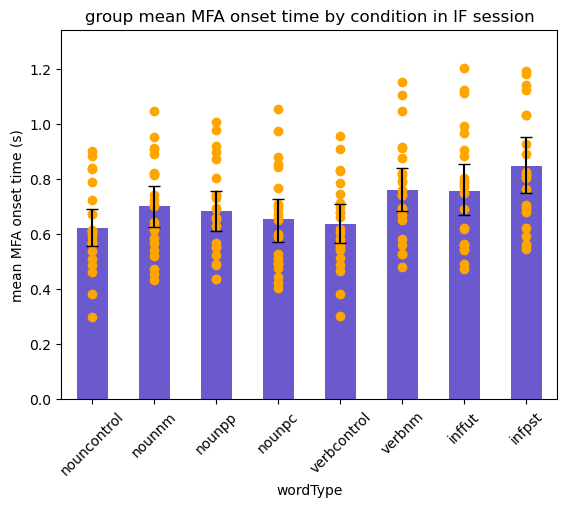

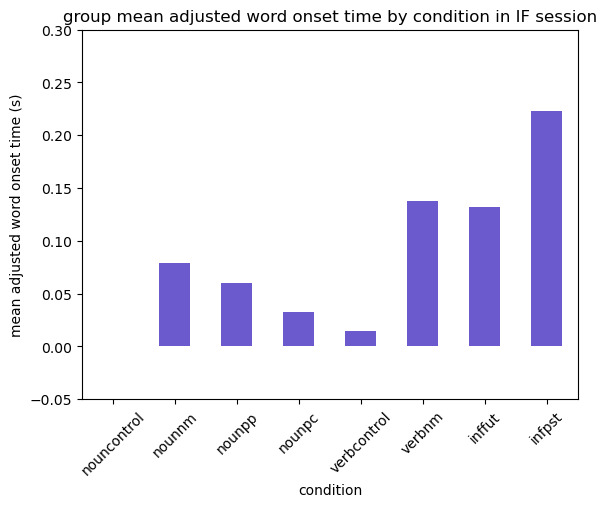

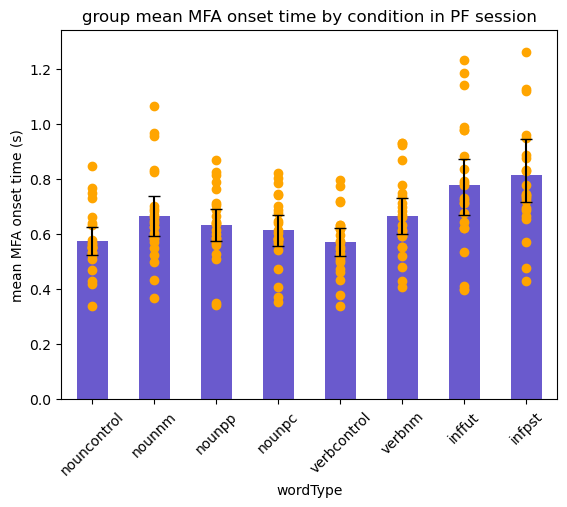

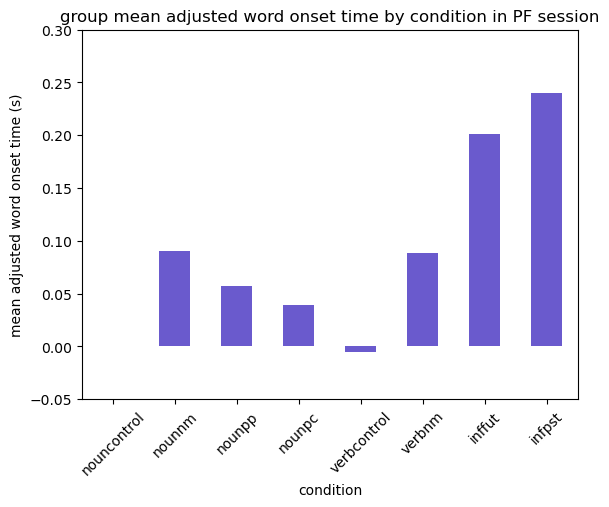

In [8]:
# getting all the subject folders
subject_folders = [item for item in os.listdir(data_dir) if item.startswith('R')]

for session in sessions:

    # create an empty list to store all the subject's data
    dataframes = []

    # loop through subject folders
    for folder in subject_folders:
    # get the result .csv file
        csv_files = glob(os.path.join(data_dir,folder, f"*_{session}_responseOnsetTime.csv"))
        # check if the file exists
        for csv_file in csv_files:
            df = pd.read_csv(csv_file)
            dataframes.append(df)

    all_data = pd.concat(dataframes, ignore_index=True)
    filtered_all_data = all_data[(all_data['MFA_sentence_onset'] > 0.4) & (all_data['incorrect'] != str(1))]
    filtered_all_data['MFA_sentence_onset'] = filtered_all_data['MFA_sentence_onset']-0.257

    new_x_labels = ['nouncontrol','nounnm','nounpp','nounpc','verbcontrol','verbnm','inffut','infpst'] 

    # getting group average and subject average MFA_onset_time
    group_average = filtered_all_data.groupby('wordType')['MFA_sentence_onset'].mean()
    subject_average = filtered_all_data.groupby(['subject','wordType'])['MFA_sentence_onset'].mean()
    
    group_average = group_average.reindex(new_x_labels)
    subject_average = subject_average.reindex(new_x_labels, level=1)

    # plot the group mean MFA onset time by condition, adding subject average as scatter points
    group_plot = group_average.plot(kind='bar', color='#6A5ACD')
    
    for wordType in group_average.index:
        condition_data = subject_average[subject_average.index.get_level_values('wordType') == wordType]
        
        mean = np.mean(condition_data.values)
        sem = stats.sem(condition_data.values)
        ci = sem * stats.t.ppf((1 + 0.95) / 2, len(condition_data.values) - 1)
        
        group_plot.scatter([wordType] * len(condition_data), condition_data.values, color='#FFA500')
        group_plot.errorbar(wordType, mean, yerr=ci, color='black', capsize = 4)
    
    group_plot.set_xticks(range(len(new_x_labels)))
    group_plot.set_xticklabels(new_x_labels)
    plt.xlabel('wordType')
    plt.ylabel('mean MFA onset time (s)')
    plt.title(f'group mean MFA onset time by condition in {session} session')
    plt.ylim(0,1.6-0.257)
    plt.xticks(rotation=45)
    plt.show()

    nouncontrol_mean = group_average['nouncontrol']
    adjusted_group_average = group_average - nouncontrol_mean
    
    nouncontrol_mean_all_subject = subject_average.loc[subject_average.index.get_level_values('wordType') == 'nouncontrol']
    adjusted_subject_average = subject_average.copy()

    for subject in nouncontrol_mean_all_subject.index.get_level_values('subject'):
        adjusted_subject_average.loc[subject] = subject_average.loc[subject].values - nouncontrol_mean_all_subject.loc[subject].values

    # plot the group mean MFA onset time by condition, adding subject average as scatter points
    adjusted_group_plot = adjusted_group_average.plot(kind='bar', color='#6A5ACD')
    
    for wordType in adjusted_group_average.index:
        
        condition_data = adjusted_subject_average[adjusted_subject_average.index.get_level_values('wordType') == wordType]
        
        # mean = np.mean(condition_data.values)
        # sem = stats.sem(condition_data.values)
        # ci = sem * stats.t.ppf((1 + 0.95) / 2, len(condition_data.values) - 1)
        
        # adjusted_group_plot.scatter([wordType] * len(condition_data), condition_data.values, color='#FFA500')
        # adjusted_group_plot.errorbar(wordType, mean, yerr=ci, color='black', capsize = 4)

    
    adjusted_group_plot.set_xticks(range(len(new_x_labels)))
    adjusted_group_plot.set_xticklabels(new_x_labels)
    plt.xlabel('condition')
    plt.ylabel('mean adjusted word onset time (s)')
    plt.title(f'group mean adjusted word onset time by condition in {session} session')
    plt.ylim(-0.05,0.3)
    plt.xticks(rotation=45)
    plt.show()